In [19]:
import numpy as np
from sklearn.metrics import log_loss,accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd 
import xgboost as xgb
import json
from collections import Counter

import gc
from tqdm import tqdm
from itertools import combinations

from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
train_df = pd.read_csv("train.csv",index_col='id')
test_df = pd.read_csv("test.csv")

train_df

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0


In [ ]:
le = LabelEncoder()

def feature_engineering(df):  
    all_cols = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    categorical_cols = ['Sex']
    
    for c in categorical_cols:
        df.drop(c,axis=1,inplace=True)
        """df[c] = le.fit_transform(df[c]) # Converts categorical column into int format
        df[c] = df[c].astype('category') # Define column type as category """

    #df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    #df['Intensity'] = df['Heart_Rate'] / df['Duration']
    
    df.drop(['Age','Height','Weight'],axis=1,inplace=True)
    #df["Body_Temp"] = np.expm1(df["Body_Temp"])
   
    df["Body_Temp"] = df["Body_Temp"]


    gc.collect()
    
    """from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df[['Duration', 'Heart_Rate', 'Body_Temp']]),
                            columns=['Duration', 'Heart_Rate', 'Body_Temp'])"""
    
            
    return df


test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

labels = train_df['Calories']
train_df.drop('Calories',axis=1,inplace=True)

train_df.describe()

,Duration,Heart_Rate,Body_Temp
count,750000.000000,750000.000000,750000.000000
mean,15.421015,95.483995,1603.509772
std,8.354095,9.449845,61.829118
min,1.000000,67.000000,1376.410000
25%,8.000000,88.000000,1568.160000
50%,15.000000,95.000000,1624.090000
75%,23.000000,103.000000,1656.490000
max,30.000000,128.000000,1722.250000


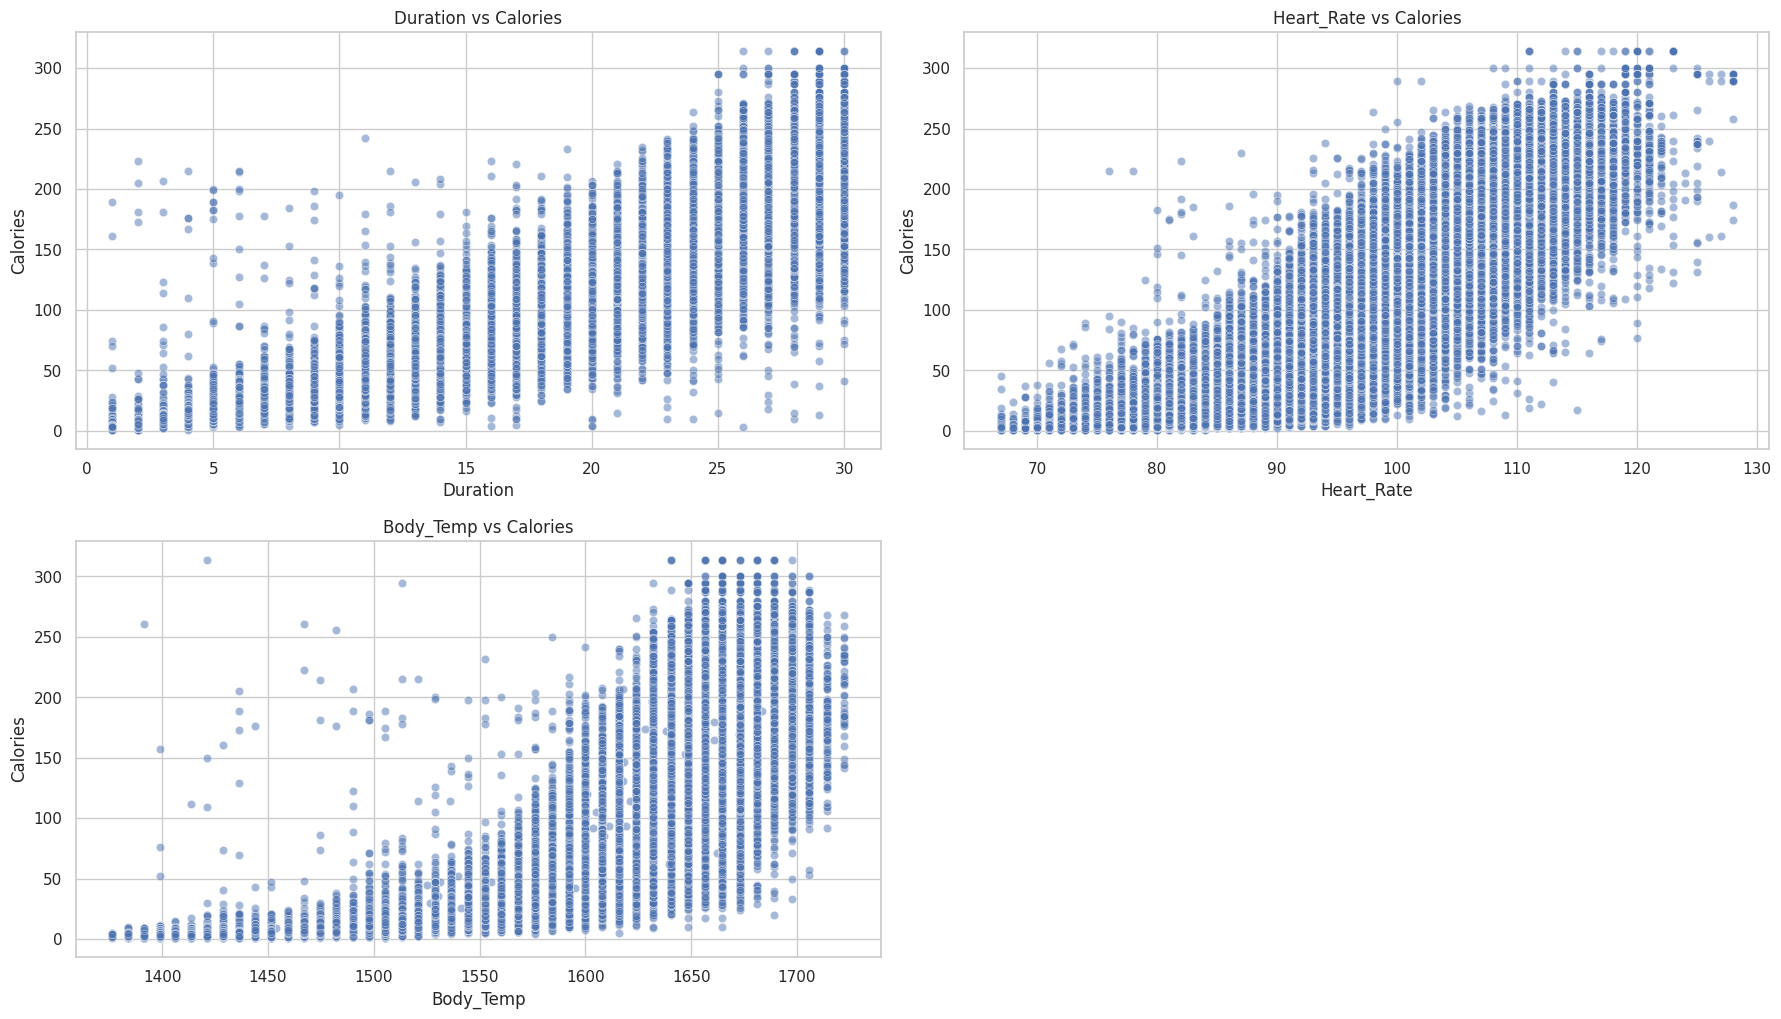

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df_with_label = train_df.copy()
train_df_with_label['Calories'] = labels

sns.set(style="whitegrid")

features = [col for col in train_df.columns]

plt.figure(figsize=(18, 20))

for idx, feature in enumerate(features):
    plt.subplot(4, 2, idx + 1)
    
    if train_df_with_label[feature].dtype.name == 'category':
        sns.boxplot(x=feature, y='Calories', data=train_df_with_label)
    else:
        sns.scatterplot(x=feature, y='Calories', data=train_df_with_label, alpha=0.5)
    
    plt.title(f'{feature} vs Calories')

plt.tight_layout()
plt.show()


In [13]:
params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'rmsle',
        
        'max_depth': 14, 'learning_rate': 0.009984120985616568, 'subsample': 0.6879090649810736, 'colsample_bytree': 0.8598186770148833, 'gamma': 0.5387763865611772, 'min_child_weight': 10, 'reg_alpha': 2.825947933310508, 'reg_lambda': 0.7106461750874411, 'max_bin': 766
}        
"""'max_depth': 5, 'learning_rate': 0.001, 'subsample': 0.80, 'colsample_bytree': 0.7439577268901377,
        'gamma': 0.8310204647109323, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.95, 'max_bin': 2632"""

"'max_depth': 5, 'learning_rate': 0.001, 'subsample': 0.80, 'colsample_bytree': 0.7439577268901377,\n        'gamma': 0.8310204647109323, 'min_child_weight': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.95, 'max_bin': 2632"

In [14]:
dtrain = xgb.DMatrix(train_df, labels, enable_categorical=True)

result = xgb.cv(
        params,
        dtrain,
        num_boost_round=100000,
        nfold=5,
        early_stopping_rounds=25,
        metrics={'rmsle'},
        seed=42,
        as_pandas=True,
        verbose_eval=250
)

[0]	train-rmsle:1.01928+0.00029	test-rmsle:1.01928+0.00143


KeyboardInterrupt: 

In [ ]:
def prep_submission(ids,preds):

    submission_df = pd.DataFrame({
        'id': ids,
        'preds' : preds[:],

    })

    submission_df.to_csv("submission.csv", index=False)
    print("Submission file saved successfully!")

In [ ]:
best_rounds = result.shape[0]
final_model = xgb.train(
        params,
        dtrain,
        num_boost_round=best_rounds+200
    )

ids= test_df["id"]
try:
    test_df_without_id = test_df.drop("id",axis=1)
except:
    pass

final_test = xgb.DMatrix(test_df_without_id,enable_categorical=True)
preds = final_model.predict(final_test)

prep_submission(ids,preds)

KeyboardInterrupt: 

In [ ]:
final_model.save_model("models/linear_model.json")